# Library

In [ ]:
import pandas as pd
import numpy as np
import requests
from io import StringIO

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Préparation des données

importer data

In [ ]:
lien_csv = "https://raw.githubusercontent.com/pierrebeguin/Master_2_defi_1/main/bacteriemie.csv"
response = requests.get(lien_csv)
data = pd.read_csv(StringIO(response.text), sep=",")

# Changer les 'no' par '0' et les 'yes' par '1'
data['BloodCulture'] = data['BloodCulture'].replace({'no': 0, 'yes': 1})

display(data.head())

<ipython-input-2-67845624eb34>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['BloodCulture'] = data['BloodCulture'].replace({'no': 0, 'yes': 1})


,ID,SEX,AGE,MCV,HGB,HCT,PLT,MCH,MCHC,RDW,...,BASOR,EOSR,LYMR,MONOR,NEU,NEUR,PDW,RBC,WBC,BloodCulture
0,1,2,62,99.3,11.5,35.9,307.0,31.5,31.8,19.5,...,0.413223,0.000000,1.652893,7.024793,22.0,90.909091,10.6,3.7,24.10,0
1,3,1,72,85.1,10.3,34.7,182.0,26.0,30.6,15.0,...,0.000000,0.826446,3.305785,1.652893,11.4,94.214876,11.4,3.9,12.17,0
2,5,1,46,96.3,7.4,22.8,64.0,31.2,32.4,19.7,...,0.568182,0.568182,8.522727,6.818182,14.7,83.522727,14.1,2.5,17.45,0
3,9,2,38,85.1,13.7,38.7,183.0,30.2,35.3,12.6,...,0.000000,0.000000,8.333333,4.166667,8.4,87.500000,12.2,4.4,9.86,0
4,10,1,68,104.5,15.7,46.9,144.0,34.8,33.5,13.9,...,0.000000,1.000000,22.000000,9.000000,6.8,68.000000,12.9,4.3,9.94,0


In [ ]:
data.groupby('BloodCulture').size()

,0
BloodCulture,
0,10809
1,944


Divisez les données en jeu d'entraînement et de test

In [ ]:
# définir X et y (features et labels)
X = data.drop(columns=['ID','BloodCulture'])
y = data['BloodCulture'].values.ravel()

# Remplacer les NA par la médiane
X.fillna(X.median(), inplace=True)

# Divisez les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify=y)

# vérifier la taille
print('taille de X_train = ',X_train.shape)
print('taille de y_train = ',y_train.shape)
print(' ')
print('taille de X_test = ',X_test.shape)
print('taille de y_test = ',y_test.shape)

taille de X_train =  (9402, 51)
taille de y_train =  (9402,)
 
taille de X_test =  (2351, 51)
taille de y_test =  (2351,)


Standardiser

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

SMOTE

In [ ]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Modèle

In [ ]:
# Définir les modèles de base
logreg = LogisticRegression(random_state=42, class_weight='balanced')
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
gb = GradientBoostingClassifier(random_state=42)
svm = SVC(probability=True, random_state=42, class_weight='balanced')

In [ ]:
# Création du modèle de stacking
estimators = [('rf', rf), ('gb', gb), ('svm', svm)]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=5)

In [ ]:
# Entraîner tous les modèles
models = {'Logistic Regression': logreg,
          'Random Forest': rf,
          'Gradient Boosting': gb,
          'SVM': svm,
          'Stacking': stacking_model}

for name, model in models.items():
  print(f"Training {name}...")
  model.fit(X_train, y_train)

Training Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Random Forest...
Training Gradient Boosting...
Training SVM...
Training Stacking...


# évaluation des modèles

In [ ]:
# Fonction pour évaluer un modèle
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(f'Precision: {precision_score(y_test, y_pred):.4f}')
    print(f'Recall: {recall_score(y_test, y_pred):.4f}')
    print(f'F1 Score: {f1_score(y_test, y_pred):.4f}')
    print(f'Confusion Matrix for {model.__class__.__name__}')
    print(confusion_matrix(y_test, y_pred))
    print('\nClassification Report')
    print(classification_report(y_test, y_pred))

for name, model in models.items():
    print(f"=== Evaluation for {name} ===")
    evaluate_model(model, X_test, y_test)

=== Evaluation for Logistic Regression ===
Accuracy: 0.7057
Precision: 0.1669
Recall: 0.6667
F1 Score: 0.2669
Confusion Matrix for LogisticRegression
[[1533  629]
 [  63  126]]

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.71      0.82      2162
           1       0.17      0.67      0.27       189

    accuracy                           0.71      2351
   macro avg       0.56      0.69      0.54      2351
weighted avg       0.90      0.71      0.77      2351

=== Evaluation for Random Forest ===
Accuracy: 0.9056
Precision: 0.3146
Recall: 0.1481
F1 Score: 0.2014
Confusion Matrix for RandomForestClassifier
[[2101   61]
 [ 161   28]]

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      2162
           1       0.31      0.15      0.20       189

    accuracy                           0.91      2351
   macro avg       0.62      0.56      0.58      2351
wei

# Courbe ROC

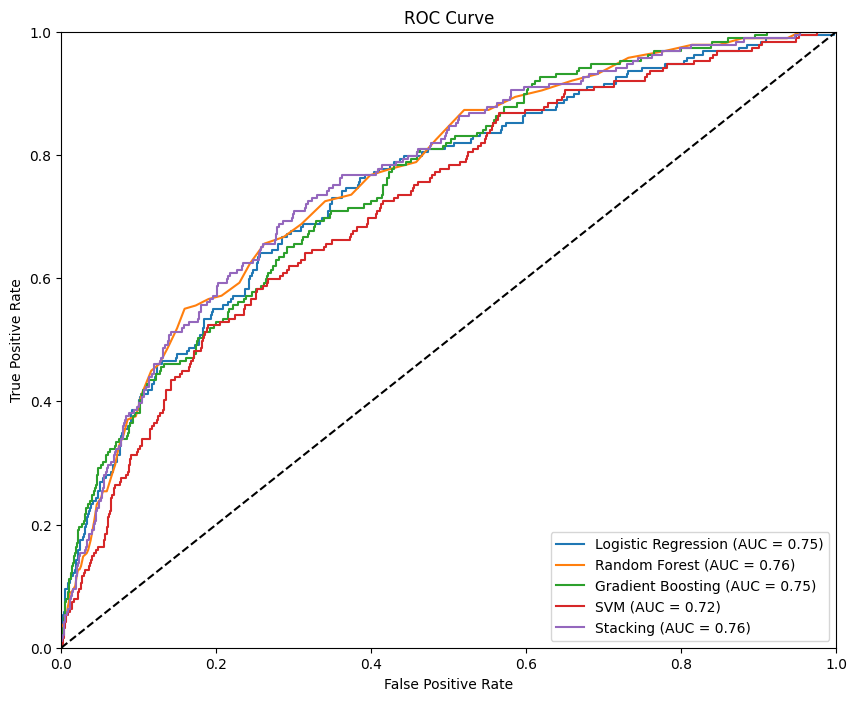

In [ ]:
plt.figure(figsize=(10, 8))

for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonale de référence
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# datat_test

In [ ]:
lien_csv = "https://raw.githubusercontent.com/pierrebeguin/Master_2_defi_1/main/bacteriemie_test.csv"
response = requests.get(lien_csv)
data_test = pd.read_csv(StringIO(response.text), sep=";")

data_test = data_test.drop(columns=['ID'])

# Remplacer les NA par la médiane
data_test.fillna(data_test.median(), inplace=True)

display(data_test.head())

,SEX,AGE,MCV,HGB,HCT,PLT,MCH,MCHC,RDW,MPV,...,CRP,BASOR,EOSR,LYMR,MONOR,NEU,NEUR,PDW,RBC,WBC
0,1,84,91.3,10.3,31.1,309.0,30.4,33.3,13.8,8.5,...,3.78,0.0,0.000000,11.016949,6.779661,9.7,82.203390,8.7,3.5,11.58
1,1,55,99.3,14.6,43.5,242.0,33.1,33.4,13.1,10.3,...,17.84,0.0,2.325581,16.279070,12.403101,8.9,68.992248,12.5,4.5,13.06
2,1,67,95.3,10.9,30.4,88.0,33.6,35.3,13.3,10.7,...,1.36,0.0,0.647256,11.642024,8.008439,7.3,77.777778,12.0,3.9,9.66
3,1,29,86.7,7.3,22.2,188.0,29.1,33.7,13.2,10.6,...,6.79,0.0,0.000000,18.867925,9.433962,3.8,71.698113,11.9,2.5,5.26
4,1,56,94.2,9.2,26.7,72.0,32.2,34.2,18.3,10.3,...,0.06,0.0,0.647256,11.642024,8.008439,7.3,77.777778,12.0,3.9,9.66


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


[0 0 0 ... 0 0 0]


In [ ]:
y_pred = stacking_model.predict(data_test)
y_pred = pd.Series(y_pred, name="Prédictions")
display(y_pred)
y_pred.value_counts()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


,Prédictions
0,0
1,0
2,0
3,0
4,0
...,...
2933,0
2934,0
2935,0
2936,0


,count
Prédictions,
0,2938
